Matching hankel function to solution to scrodinger equation

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.special import spherical_jn, spherical_yn

Defining hankel functions for solutions outside muffin tin 

$$ u(r)=-i^{l+1}\,r\,h_l(\kappa r) $$


define derivative of $ u(r)$ 

$$ \frac{du}{dr}=-i^{l+1}\left(h_l(\kappa r)+r\,\frac{dh_l(\kappa r)}{dr}\right)$$

In [72]:


def spherical_hankel(l, r,k):

    j = r*spherical_jn(l, r*k)
    y = r*spherical_yn(l, r*k)
    h = -1j*(j + 1j*y)*1j**(l+1)

    dj = r*spherical_jn(l, r*k, derivative=True)*k
    dy = r*spherical_yn(l, r*k, derivative=True)*k
    dh_dx = -1j * (dj + 1j*dy) * (1j**(l+1))

    dh = (h/r + dh_dx)
    return h, dh


define schrodinger ode 

 $$ \left[\frac{h^2}{2m}\frac{d^2}{dr^2}+\left(E-V(r)-\frac{\hbar^2l(l+1)}{2mr^2}\right)\right]u_l(r)=0 $$

 solve in Rydburg units $\frac{\hbar^2}{4m} = 1 \rm {Ry}$

 $$-\,\frac{d^2 u(r)}{dr^2} \;+\; \biggl[ \frac{l(l+1)}{r^2} \;-\;\frac{2Z}{r}\biggr] \,u(r)\;=\;E\,u(r)\,. $$



In [73]:
def schrod_ode(r, y, E, l):
    """
    second order ode to first order
    """
    u, up = y
    return [up,(l * (l + 1) / r**2 - 2.0 / r - E) * u]

def schrod_int(E, l, boundary_conditions, r_min, R, num_points=3000):

    r_values = np.linspace(r_min, R, num_points)
    sol = solve_ivp(schrod_ode,(r_min, R),boundary_conditions,method='DOP853',t_eval=r_values,args=(E, l)
    )
    return r_values, sol.y[0], sol.y[1]

best E = -0.024974
best A = 4333606.143754


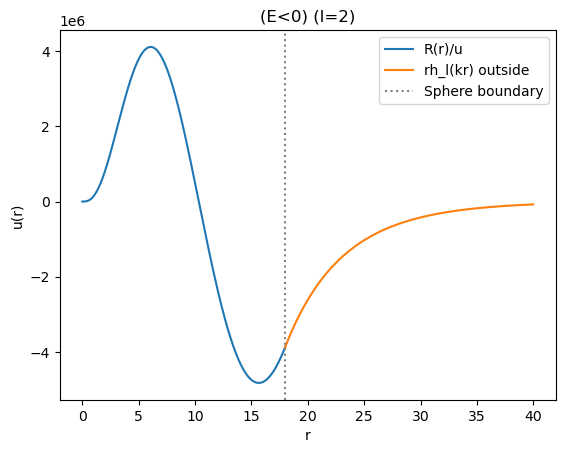

In [78]:
def residual_match(vars, l, boundary_conditions, r_min, R):

    E, A = vars


    k = np.sqrt(E_best + 0j)


    r_vals, u_vals, up_vals = schrod_int(E, l, boundary_conditions, r_min, R)
    uR  = u_vals[-1]   # wavefunction at R
    upR = up_vals[-1]  # derivative at R

    h_val, dh_val = spherical_hankel(l,  R,k)

    res1 = (uR- A * h_val).real
    res2 = (upR - A * ( dh_val)).real

    return [res1, res2]

def solver(E_guess, A_guess, l, boundary_conditions, r_min, R):

    x0 = [E_guess, A_guess]
    sol = fsolve(
        residual_match,
        x0,
        args=(l, boundary_conditions, r_min, R),
        xtol=1e-12
    )
    return sol

def plotting(E_best, A_best, l, boundary_conditions, r_min, R,
                           r_extend=40, r_num=1000):

    r_in, u_in, up_in = schrod_int(E_best, l, boundary_conditions, r_min, R, r_num)

    plt.plot(r_in, u_in.real, label="R(r)/u")

    r_out = np.linspace(R, r_extend, r_num)
    
    # if E_best <= 0:
    #     k = 1j*np.sqrt(np.abs(E_best))
    # else:
    #     k = np.sqrt(E_best)

    k = np.sqrt(E_best + 0j)


    hankel_vals,_=spherical_hankel(l,r_out,k)
    hankel_vals = A_best * hankel_vals


    plt.plot(r_out, hankel_vals.real, label="rh_l(kr) outside")


    plt.axvline(R, color='gray', linestyle=':', label="Sphere boundary")

    plt.xlabel("r")
    plt.ylabel("u(r)")
    plt.title(f"(E<0) (l={l})")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    l = 2
    bc = [0.0, 1.0]
    r_min = 1e-3
    R = 18

    E_guess = -.06
    A_guess = -50.0
    E_best, A_best = solver(E_guess, A_guess, l, bc, r_min, R)

    print(f"best E = {E_best:.6f}")
    print(f"best A = {A_best:.6f}")

    plotting(E_best, A_best, l, bc, r_min, R, r_extend=40.0)